In [74]:
import wbgapi as wb
import wbdata
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # For scaling dataset


from sklearn.metrics import r2_score

import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')

<h1 style="color:black; background-color:white; padding:10px; padding-bottom:10px;text-align: center;">Green dimensions</h1>

---

In [ ]:
def load_and_name_db_WB(db, *args):
    global df_name
    df_name = db
    globals()[df_name] = wb.data.DataFrame(value1, wb.region.members(value2), range(value3, value4))

    return globals()[df_name]

In [ ]:
value1 = ['EN.ATM.CO2E.PC','EG.FEC.RNEW.ZS',"NY.GDP.MKTP.KD.ZG",'SL.UEM.TOTL.ZS']
value2 = "WLD"
value3 = 2019
value4 = 2020

load_and_name_db_WB("df_original", value1, value2, value3, value4, new_column_names)

,EG.FEC.RNEW.ZS,EN.ATM.CO2E.PC,NY.GDP.MKTP.KD.ZG,SL.UEM.TOTL.ZS
economy,,,,
ABW,7.48,NaN,0.635029,NaN
AFG,18.51,0.160850,3.911603,11.085
AGO,54.69,0.779292,-0.700000,9.481
ALB,40.20,1.691968,2.088063,11.470
AND,18.40,6.573595,2.015548,NaN
...,...,...,...,...
XKX,26.10,NaN,4.756831,NaN
YEM,3.11,0.351701,NaN,12.978
ZAF,10.50,7.568640,0.303453,25.540


In [50]:
def rename_columns_and_drop_na(df, column_mapping):
    # Rename columns
    df = df.rename(columns=column_mapping)

    # Drop rows with missing values
    df = df.dropna()

    return df

# Example usage
# Assuming you have a DataFrame named 'df' and a dictionary of column mapping named 'column_mapping'
column_mapping = {'EN.ATM.CO2E.PC': 'CO2_per_cap', 'EG.FEC.RNEW.ZS': 'ren_en_consum', 'NY.GDP.MKTP.KD.ZG': 'GDP_growth', 'SL.UEM.TOTL.ZS': 'Unemployment'}
new_df = rename_columns_and_drop_na(df_original, column_mapping)
new_df

,ren_en_consum,CO2_per_cap,GDP_growth,Unemployment
economy,,,,
AFG,18.51,0.160850,3.911603,11.085
AGO,54.69,0.779292,-0.700000,9.481
ALB,40.20,1.691968,2.088063,11.470
ARE,0.67,20.502131,1.108348,2.330
ARG,10.74,3.740546,-2.000861,9.840
...,...,...,...,...
VUT,31.86,0.692501,3.241188,1.757
WSM,34.21,1.394021,4.451859,9.147
ZAF,10.50,7.568640,0.303453,25.540


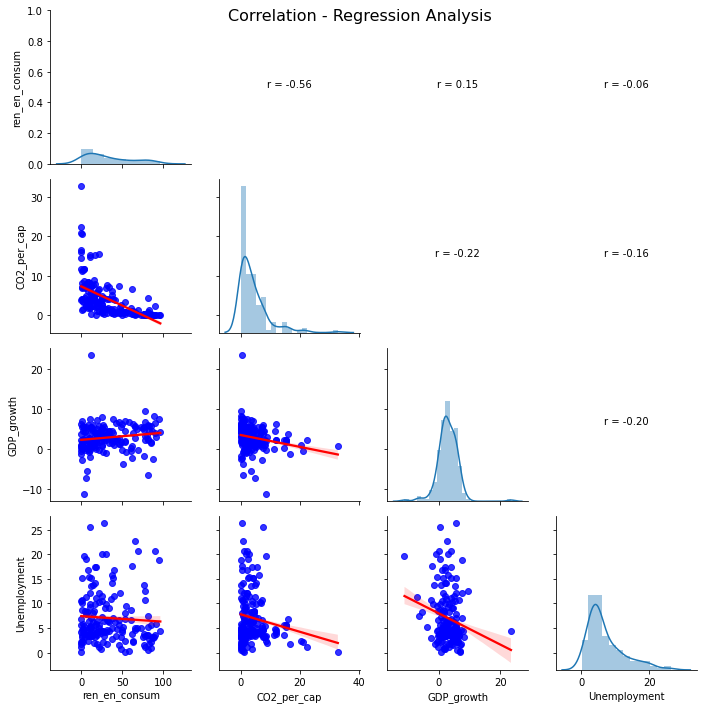

In [52]:
from scipy.stats import pearsonr
def reg_coef(x, y, label=None, color=None, **kwargs):
    ax = plt.gca()
    r, p = pearsonr(x, y)
    ax.annotate('r = {:.2f}'.format(r), xy=(0.5, 0.5), xycoords='axes fraction', ha='center')
    ax.set_axis_off()

def reg_plot(x, y, **kwargs):
    color = kwargs.pop('color', 'red')
    sns.regplot(x, y, color=color, ci=68, scatter_kws={'color': 'blue'}, line_kws={'color': color}, **kwargs)

g = sns.PairGrid(new_df)
g.map_diag(sns.distplot)
g.map_lower(reg_plot, color='red')
g.map_upper(reg_coef)

plt.suptitle('Correlation - Regression Analysis', fontsize=16)

plt.show()

In [88]:
def dimensional_reduction(dataframe):
    # Standardize the data
    dataframe = dataframe.dropna()
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(dataframe)

    # Perform PCA
    pca = PCA()
    pca.fit(standardized_data)

    # Get the explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variances = np.cumsum(explained_variance_ratio)

    # Create subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))

    # Scree plot to visualize explained variance ratio
    axs[0].plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
    axs[0].set_xlabel('Number of Components')
    axs[0].set_ylabel('Explained Variance Ratio')
    axs[0].set_title('Explained Variance Ratio by Principal Components')

    # Cumulative variance plot
    axs[1].plot(range(1, len(cumulative_variances) + 1), cumulative_variances, marker='o')
    axs[1].set_xlabel('Number of Components')
    axs[1].set_ylabel('Cumulative Variance Explained')
    axs[1].set_title('Cumulative Variance Explained by Principal Components')
    axs[1].axhline(0.90, c="r")

    # Find the number of components exceeding the threshold
    n_components = np.argmax(cumulative_variances >= 0.90) + 1

    # Add text annotation to the second scatter plot
    axs[1].text(n_components, cumulative_variances[n_components - 1], f'The optimal number of components\n to explain at least 95% variance is: {n_components}', fontsize=12,
                ha='center', va='bottom')

    # Adjust the layout
    plt.tight_layout()

    # Show the plots
    plt.show()


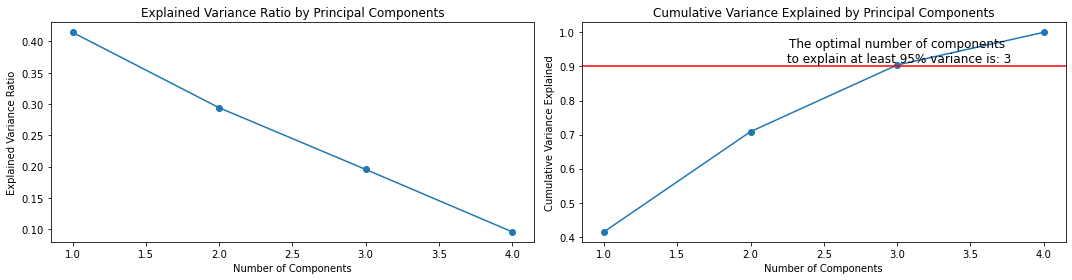

In [89]:
dimensional_reduction(new_df)

In [63]:
import numpy as np
from sklearn.cluster import KMeans

def dimensional_reduction3(df, model):
    df = df.dropna(axis=0, how='any')

    dm = model
    dm = dm.fit(df)
    global df_tr
    df_tr = dm.transform(df)
    dm_df = pd.DataFrame(data=dm.components_, columns=df.columns.values, index=range(len(dm.components_)))

    fig = plt.figure(figsize=(12, 12))

    # Plot the correlation heatmap
    ax_heatmap = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    sns.heatmap(dm_df, vmin=-1, vmax=1, annot=True, cmap='RdBu', ax=ax_heatmap)
    ax_heatmap.set_title('Correlation Heatmap')

    # Plot the scatter plot of PCA components with KMeans clustering
    ax_scatter1 = plt.subplot2grid((2, 2), (1, 0))
    ax_scatter1.scatter(df_tr[:, 0], df_tr[:, 1], c=KMeans(n_clusters=3).fit_predict(df_tr))
    ax_scatter1.set_title('PCA Scatter Plot with KMeans Clustering')
    ax_scatter1.set_xlabel('Principal Component 1')
    ax_scatter1.set_ylabel('Principal Component 2')

    # Plot the second scatter plot with column names as labels
    ax_scatter2 = plt.subplot2grid((2, 2), (1, 1))
    ax_scatter2.scatter(dm.components_[0], dm.components_[1])
    ax_scatter2.set_title('Scatter Plot 2')
    ax_scatter2.set_xlabel('Principal Component 1')
    ax_scatter2.set_ylabel('Principal Component 2')

    for i, txt in enumerate(df.columns):
        ax_scatter2.annotate(txt, (dm.components_[0][i], dm.components_[1][i]))

    plt.tight_layout()
    plt.show()

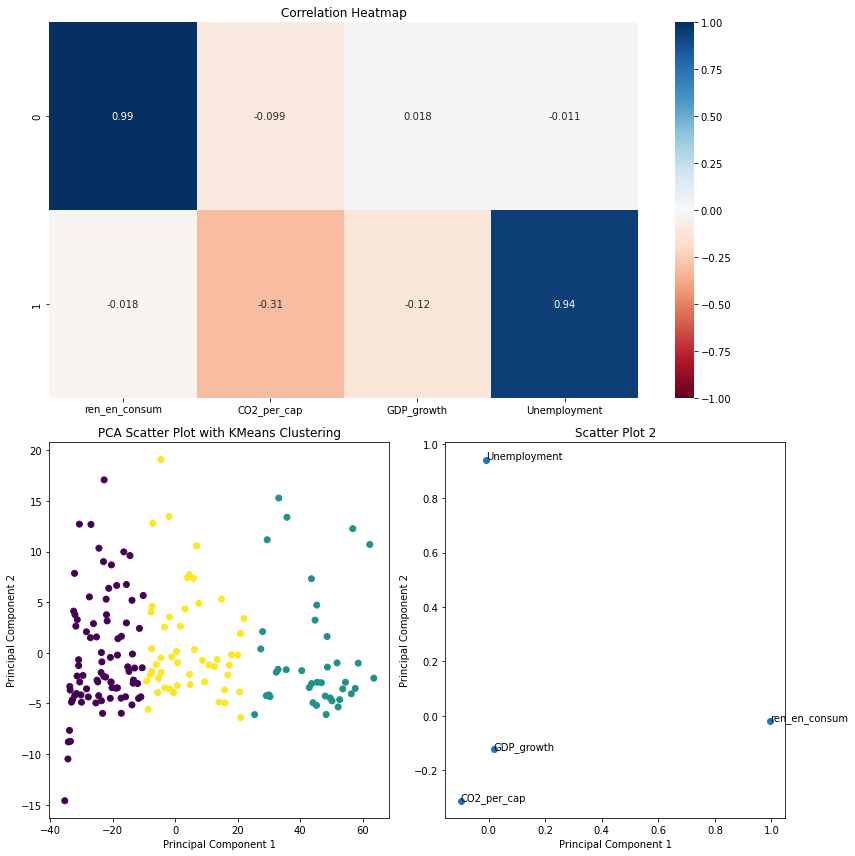

In [65]:
dimensional_reduction3(new_df, PCA(2))